In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

# Load MNIST dataset directly (Kaggle kernels should have internet access enabled)
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"].astype(np.float32), mnist["target"].astype(int)

# Train-test split (stratified subset for train, full test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, stratify=y, random_state=42)
X_train, y_train = X_train[:10000], y_train[:10000]  # Use a smaller subset if compute is limited

# Convert to NumPy arrays and then to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values)
y_train_tensor = torch.tensor(y_train.values)
X_test_tensor = torch.tensor(X_test.values)
y_test_tensor = torch.tensor(y_test.values)

# Create PyTorch DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define MLP model in PyTorch
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss, and optimizer
mlp = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Train the MLP model
num_epochs = 10
for epoch in range(num_epochs):
    mlp.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = mlp(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

# Evaluate MLP on test data
mlp.eval()
y_pred_mlp = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = mlp(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred_mlp.extend(predicted.tolist())
        y_true.extend(y_batch.tolist())

# F1-score for MLP
f1_mlp = f1_score(y_true, y_pred_mlp, average='weighted')
print(f"MLP F1 Score: {f1_mlp}")

# Sklearn models
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
print(f"Random Forest F1 Score: {f1_rf}")

# Logistic Regression
lr = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
print(f"Logistic Regression F1 Score: {f1_lr}")

# Confusion Matrix and Classification Report
print("\nMLP Confusion Matrix:\n", confusion_matrix(y_true, y_pred_mlp))
print("\nMLP Classification Report:\n", classification_report(y_true, y_pred_mlp))

print("\nRandom Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

print("\nLogistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))


/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


MLP F1 Score: 0.9383561870648295
Random Forest F1 Score: 0.9455238047376139


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression F1 Score: 0.8541443121609429

MLP Confusion Matrix:
 [[ 943    2    2    0    1   16    9    1    9    3]
 [   0 1094    2    6    3    3    3    7    7    0]
 [   4    6  917   12    2    4   11   30   13    0]
 [   2    5   12  945    0   16    1   20   16    3]
 [   1    0    3    0  930    1    6    3    2   29]
 [   2    5    1   17    2  833   13    1   13   15]
 [   3    0    1    1    2   14  959    0    2    0]
 [   4    8    4    2    4    3    0  989    3   25]
 [   3    7    4   31    3   18   11   13  872   13]
 [   4    6    2   17   42    4    1   13    3  902]]

MLP Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       986
           1       0.97      0.97      0.97      1125
           2       0.97      0.92      0.94       999
           3       0.92      0.93      0.92      1020
           4       0.94      0.95      0.95       975
           5       0.91      0.92      0.9

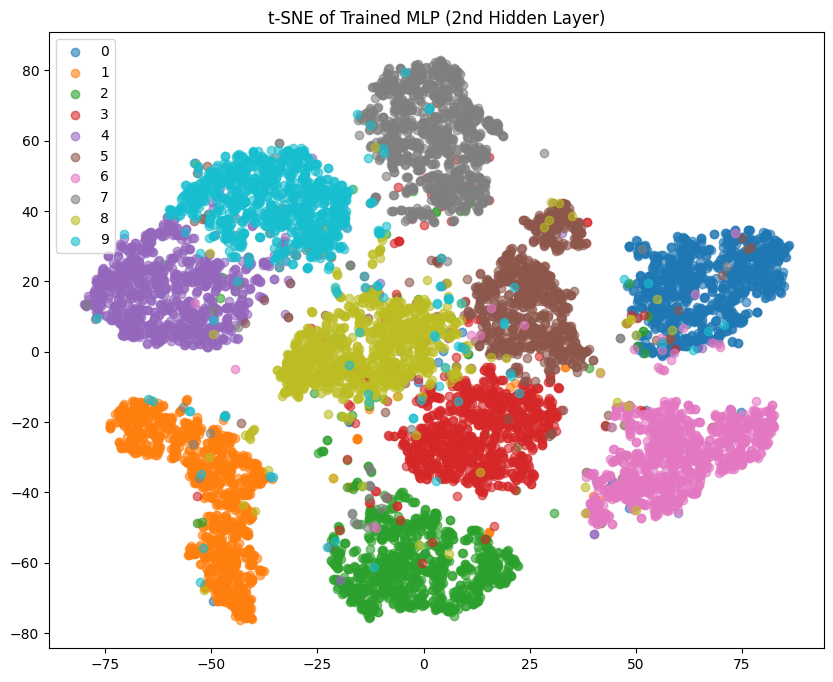

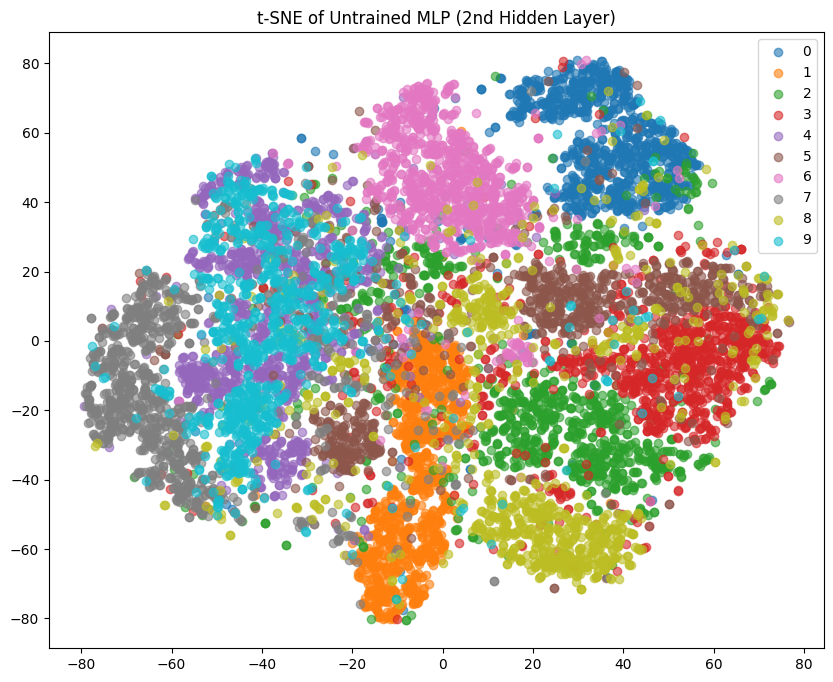

In [2]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Define function to get activations from the 2nd hidden layer
def get_activations(model, dataloader):
    activations = []
    labels = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            x = torch.relu(model.fc1(X_batch))
            x = model.fc2(x)  # Output of 2nd hidden layer
            activations.append(x)
            labels.append(y_batch)
    activations = torch.cat(activations).numpy()
    labels = torch.cat(labels).numpy()
    return activations, labels

# t-SNE visualization function
def plot_tsne(activations, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    activations_2d = tsne.fit_transform(activations)
    plt.figure(figsize=(10, 8))
    for i in range(10):
        indices = labels == i
        plt.scatter(activations_2d[indices, 0], activations_2d[indices, 1], label=str(i), alpha=0.6)
    plt.title(title)
    plt.legend()
    plt.show()

# Get activations and plot t-SNE for trained MLP
trained_activations, trained_labels = get_activations(mlp, test_loader)
plot_tsne(trained_activations, trained_labels, "t-SNE of Trained MLP (2nd Hidden Layer)")

# Initialize an untrained model and get activations for it
untrained_mlp = MLP()
untrained_activations, untrained_labels = get_activations(untrained_mlp, test_loader)
plot_tsne(untrained_activations, untrained_labels, "t-SNE of Untrained MLP (2nd Hidden Layer)")


100%|██████████| 26421880/26421880 [00:11<00:00, 2252467.97it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 208277.05it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1294271.29it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8863824.71it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



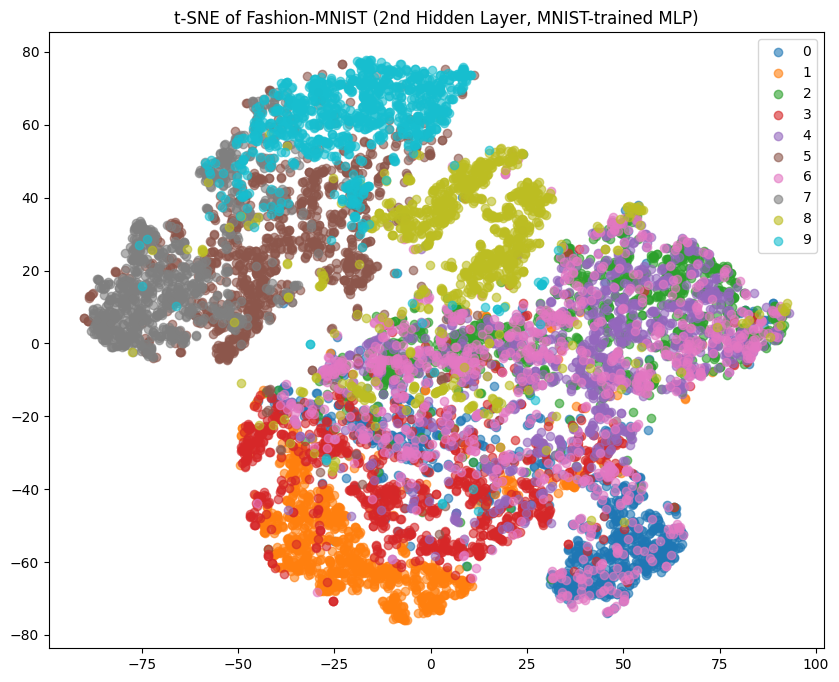

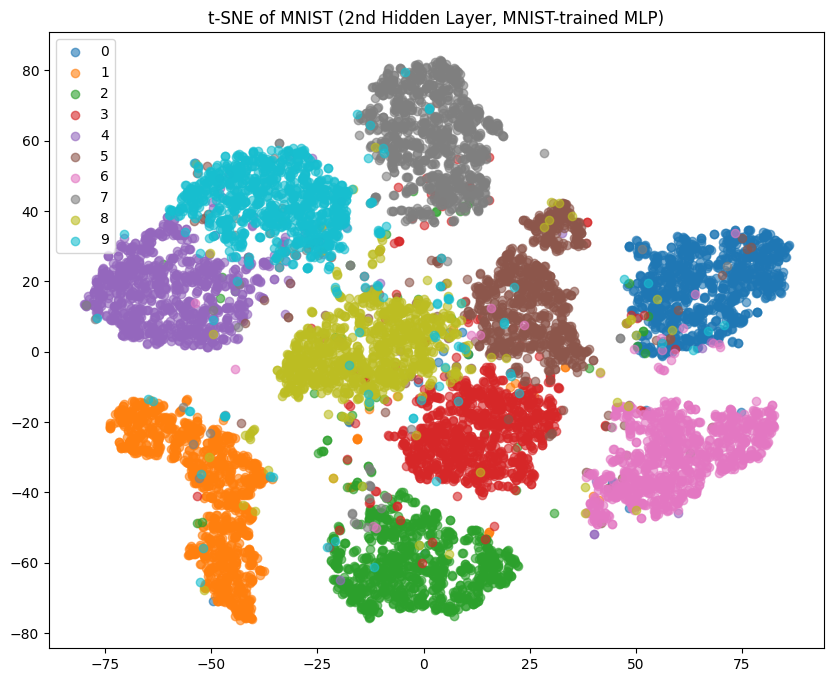

In [3]:
from torchvision import datasets, transforms

# Load Fashion-MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
fashion_mnist = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
fashion_loader = DataLoader(fashion_mnist, batch_size=64, shuffle=False)

# Get activations for Fashion-MNIST using the trained MLP
fashion_activations, fashion_labels = get_activations(mlp, fashion_loader)

# Plot t-SNE for the second layer of Fashion-MNIST
plot_tsne(fashion_activations, fashion_labels, "t-SNE of Fashion-MNIST (2nd Hidden Layer, MNIST-trained MLP)")

# (Optional) Plot t-SNE for MNIST for easy comparison (you may reuse the previous t-SNE plot for trained MNIST)
plot_tsne(trained_activations, trained_labels, "t-SNE of MNIST (2nd Hidden Layer, MNIST-trained MLP)")


In [4]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Predict on Fashion-MNIST dataset using the MNIST-trained MLP model
fashion_y_pred = []
fashion_y_true = []

mlp.eval()
with torch.no_grad():
    for X_batch, y_batch in fashion_loader:
        outputs = mlp(X_batch)
        _, predicted = torch.max(outputs, 1)
        fashion_y_pred.extend(predicted.tolist())
        fashion_y_true.extend(y_batch.tolist())

# Calculate and display performance metrics
# Accuracy
accuracy = accuracy_score(fashion_y_true, fashion_y_pred)
print(f"Accuracy on Fashion-MNIST with MNIST-trained MLP: {accuracy:.4f}")

# F1 Score
f1 = f1_score(fashion_y_true, fashion_y_pred, average='weighted')
print(f"F1 Score on Fashion-MNIST with MNIST-trained MLP: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(fashion_y_true, fashion_y_pred)
print("Confusion Matrix on Fashion-MNIST with MNIST-trained MLP:\n", conf_matrix)

# Classification Report
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_report = classification_report(fashion_y_true, fashion_y_pred, target_names=class_names)
print("Classification Report on Fashion-MNIST with MNIST-trained MLP:\n", class_report)


Accuracy on Fashion-MNIST with MNIST-trained MLP: 0.0991
F1 Score on Fashion-MNIST with MNIST-trained MLP: 0.0273
Confusion Matrix on Fashion-MNIST with MNIST-trained MLP:
 [[956   0   0  37   0   5   2   0   0   0]
 [974   0   0   0   0   0  26   0   0   0]
 [947   0   0  32   0  17   4   0   0   0]
 [946   0   0   2   0   5  47   0   0   0]
 [967   0   0  23   0   4   6   0   0   0]
 [744   0  43  50  56  30  77   0   0   0]
 [953   0   0  40   0   4   3   0   0   0]
 [290   0  43 175  72   3 417   0   0   0]
 [746   0   1 124   3  93  33   0   0   0]
 [308   0  38 644   0   7   3   0   0   0]]
Classification Report on Fashion-MNIST with MNIST-trained MLP:
               precision    recall  f1-score   support

 T-shirt/top       0.12      0.96      0.22      1000
     Trouser       0.00      0.00      0.00      1000
    Pullover       0.00      0.00      0.00      1000
       Dress       0.00      0.00      0.00      1000
        Coat       0.00      0.00      0.00      1000
      S

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
